## Classification
1. Feature processing: scaling, selection
2. Classify

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from random import sample

plt.style.use('ggplot')
%matplotlib inline

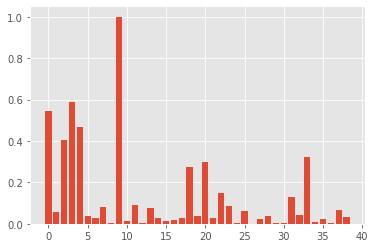

In [227]:
# 2. feature processing
import scipy.stats as stats
from joblib import dump, load
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

years = 5
df_train = pd.read_csv(f"data/{years}y/train.csv", index_col=0).to_numpy()
df_valid = pd.read_csv(f"data/{years}y/valid.csv", index_col=0).to_numpy()
X_train, y_train = df_train[:, :-1], df_train[:, -1]
X_valid, y_valid = df_valid[:, :-1], df_valid[:, -1]
y_train = ["red" if y == 0 else "green" for y in y_train]

# # numerical_features = list(range(8))
# numerical_features = list(range(8))+list(range(20, 24))
# # numerical_features = list(range(len(X_train[0])))
# preprocess_std = ColumnTransformer(
#                             transformers = [('stand', StandardScaler(), numerical_features)], 
#                             remainder="passthrough"
#                             )

# preprocess_minmax = ColumnTransformer(
#                             transformers = [('minmax', MinMaxScaler(), numerical_features)], 
#                             remainder="passthrough"
#                             )

# preprocess_maxabs = ColumnTransformer(
#                             transformers = [('maxabs', MaxAbsScaler(), numerical_features)], 
#                             remainder="passthrough"
#                             )

from sklearn.feature_selection import SelectKBest, SelectPercentile, f_classif, chi2
# selector = SelectKBest(f_classif, k=15)
selector = SelectKBest(chi2, k=10)
selector.fit(X_train, y_train)
scores = -np.log10(selector.pvalues_)
scores /= scores.max()
plt.bar(range(df_train.shape[-1]-1), scores)

# all 39 features
X = StandardScaler().fit_transform(X_train)

# top 10 features
X_top = X[:, selector.get_support()]

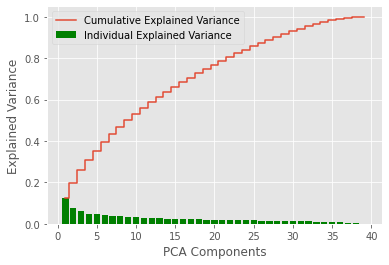

In [228]:
pca = PCA()
pca.fit(X)
plt.step(range(1, X.shape[1] + 1), pca.explained_variance_ratio_.cumsum(), 
         where='mid', label='Cumulative Explained Variance')
plt.bar(range(1, X.shape[1] + 1), pca.explained_variance_ratio_, 
        color='g', label='Individual Explained Variance')
plt.ylabel('Explained Variance')
plt.xlabel('PCA Components')
plt.legend()

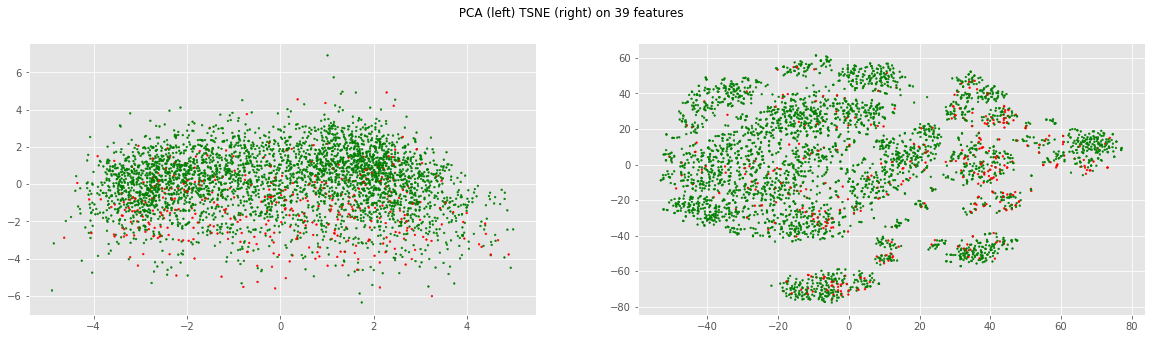

In [229]:
from collections import Counter
from imblearn.under_sampling import OneSidedSelection, EditedNearestNeighbours, ClusterCentroids

def plot_pca_tsne(X, y, name=""):
    fig = plt.figure(figsize=(20, 5)) 
    fig_dims = (1, 2)
    fig.subplots_adjust(hspace=0.2, wspace=0.2)

    plt.subplot2grid(fig_dims, (0, 0))
    X_pca = PCA(n_components=2).fit_transform(X)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], s=3, c=y)

    plt.subplot2grid(fig_dims, (0, 1))
    X_embedded = TSNE(n_components=2).fit_transform(X)
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=3, c=y)
    plt.suptitle(f"{name} PCA (left) TSNE (right) on {X.shape[1]} features")

# # visualize 3D plot
# from mpl_toolkits.mplot3d import Axes3D
# fig = plt.figure(figsize=(7,5))
# ax = fig.add_subplot(111, projection='3d')
# fig.patch.set_facecolor('white')
# ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], s=3, c=y_train)

# plot with all the 39 features
plot_pca_tsne(X, y_train)

# plot with top 10 features
# plot_pca_tsne(X_top, y_train)

Counter({'green': 3557, 'red': 377})
Counter({'green': 472, 'red': 377})


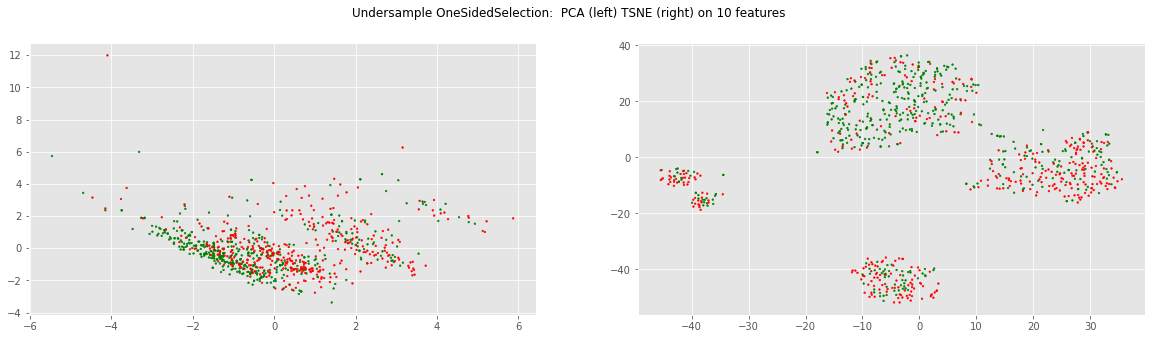

In [217]:
undersample = OneSidedSelection(n_neighbors=500, n_seeds_S=500)
X_u, y_u = undersample.fit_resample(X_top, y_train)
print(Counter(y_train))
print(Counter(y_u))

plot_pca_tsne(X_u, y_u, name="Undersample OneSidedSelection: ")

Counter({'green': 3557, 'red': 377})
Counter({'green': 521, 'red': 377})


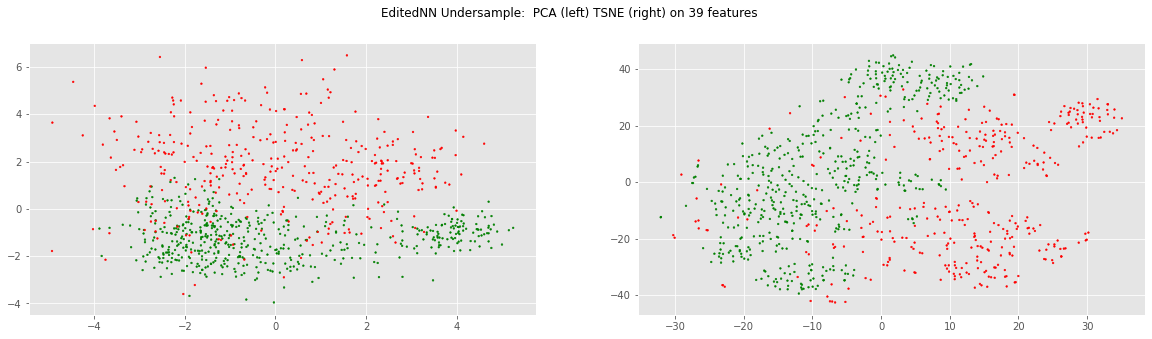

In [225]:
undersample = EditedNearestNeighbours(n_neighbors=40)
X_u, y_u = undersample.fit_resample(X, y_train)
print(Counter(y_train))
print(Counter(y_u))

plot_pca_tsne(X_u, y_u, name="EditedNN Undersample: ")

Counter({'green': 3557, 'red': 377})
Counter({'green': 377, 'red': 377})


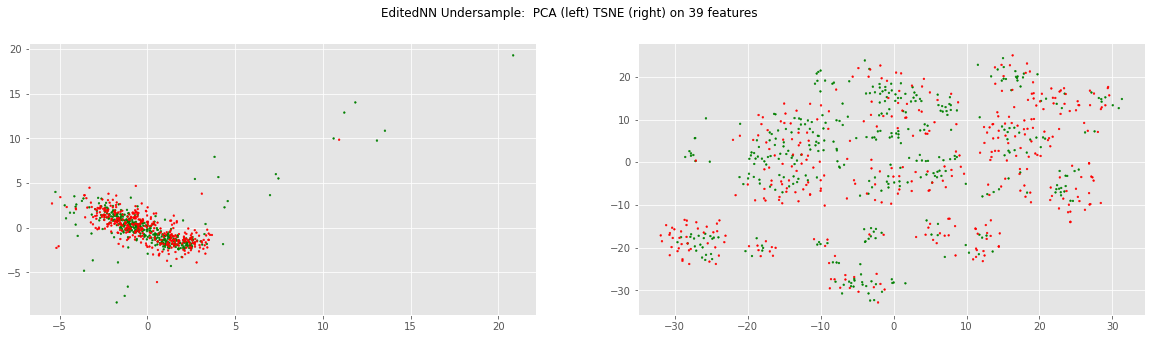

In [226]:
undersample = ClusterCentroids()
X_u, y_u = undersample.fit_resample(X, y_train)
print(Counter(y_train))
print(Counter(y_u))

plot_pca_tsne(X_u, y_u, name="EditedNN Undersample: ")